Imports

In [1]:
import folium
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import requests
import numpy as np
import shapely
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import seaborn as sb

Load raw data

In [2]:
path=os.getcwd()
path=path[:-9]
path=path+'data/raw/corona/se_corona.csv'
corona=pd.read_csv(path,low_memory=False,delimiter='\t')

#loading denmark
path=os.getcwd()
path=path[:-9]
path=path+'data/raw/corona/dk_corona.csv'
coronadk=pd.read_csv(path,low_memory=False,delimiter='\t')

In [3]:
#Loading in the metadata for sweden
path=os.getcwd() #'something\\somthingelse\\fyp2021\\notebooks'
path=path[:-9] #'something\\somthingelse\\fyp2021\\'
path=path+'data/raw/metadata/se_metadata.json' #'something/somthingelse/fyp2021/data\\raw\\corona\\se_corona.csv'
f=open(path,'r')
metadata=json.load(f)
f.close()
#Loading in denmark
path=os.getcwd() #'something\\somthingelse\\fyp2021\\notebooks'
path=path[:-9] #'something\\somthingelse\\fyp2021\\'
path=path+'data/raw/metadata/dk_metadata.json' #'something/somthingelse/fyp2021/data\\raw\\corona\\se_corona.csv'
f=open(path,'r')
metadatadk=json.load(f)
f.close()

codes=[]#adding iso codes to corona 
places=[]
for i in metadata['country_metadata']:
    codes.append(i['iso3166-2_code'])
    places.append(i['iso3166-2_name_en'])

newcol=[]
for i in corona['region_code']:
    ind=places.index(i)
    newcol.append(codes[ind])

corona['isocodes']=newcol
corona

#adding corona iso codes for denmark
codesdk=[]
placesdk=[]
for i in metadatadk['country_metadata']:
    codesdk.append(i['iso3166-2_code'])
    placesdk.append(i['iso3166-2_name_en'])

newcol=[]
for i in coronadk['region_code']:
    ind=placesdk.index(i)
    newcol.append(codesdk[ind])

coronadk['isocodes']=newcol
corona

,date,region_code,confirmed_addition,isocodes
0,2021-02-18,Blekinge,23,SE-K
1,2021-02-17,Blekinge,30,SE-K
2,2021-02-16,Blekinge,50,SE-K
3,2021-02-15,Blekinge,3,SE-K
4,2021-02-14,Blekinge,3,SE-K
...,...,...,...,...
7996,2020-02-08,Östergötland,0,SE-E
7997,2020-02-07,Östergötland,0,SE-E
7998,2020-02-06,Östergötland,0,SE-E
7999,2020-02-05,Östergötland,0,SE-E


In [4]:
#Creating a cases per region dictionary
casesperregion=dict()
for i in codes:
    casesperregion[i]=0
for i in codes:
    newcol=corona.loc[corona['isocodes']==i]['confirmed_addition']
    casesperregion[i]=sum(newcol)

#Doing the same thing for Denmark
casesperregiondk=dict()
for i in codesdk:
    casesperregiondk[i]=0
for i in codesdk:
    newcol=coronadk.loc[coronadk['isocodes']==i]['hospitalized_addition']
    casesperregiondk[i]=sum(newcol)



In [5]:
coronabyiso=pd.DataFrame()#calculationg the population of each region 
coronabyiso['isocodes']=casesperregion.keys()
coronabyiso['cases']=casesperregion.values()
newcol=[]
for i in metadata['country_metadata']:
    newcol.append(i['population'])
coronabyiso['population']=newcol

#Denamrk part
coronabyisodk=pd.DataFrame()
coronabyisodk['isocodes']=casesperregiondk.keys()
coronabyisodk['cases']=casesperregiondk.values()
newcol=[]
for i in metadatadk['country_metadata']:
    newcol.append(i['population'])
coronabyisodk['population']=newcol


In [6]:
path=os.getcwd()#grabbing the shpefiles
path=path[:-9]
path=path+'data/raw/shapefiles/se.geojson'

with open(path) as f:
  shapefiles = json.load(f)

#same thing for denmark:
path=os.getcwd()
path=path[:-9]
path=path+'data/raw/shapefiles/dk.geojson'

with open(path) as f:
  shapefilesdk = json.load(f)
#added commen

Exploratoy weather data analysis

In [7]:
path=os.getcwd()#Finding path on current machine 
path=path[:-9]
path=path+'data/raw/weather/weather.csv'
weather=pd.read_csv(path,low_memory=False,delimiter='\t')#Loading in the data
mask=[]#creating a mask with true and false values where location is sweden
for i in weather['iso3166-2']:
    if i[0:2]!='SE':
        mask.append(False)
    else:
        mask.append(True)
mask=pd.DataFrame(mask)
mask=weather['iso3166-2'][mask.any(True)]#making the mask values instead of boolean array
weather=weather.loc[weather['iso3166-2'].isin(mask)] #sorting weather by all values in mask making it sweden
weather['TemperatureAboveGround']=weather['TemperatureAboveGround']-273.15#converting to celcius 
weather['UVIndex']=weather['UVIndex']/24
#making the supplement data a part of it
path=os.getcwd()#Finding path on current machine 
path=path[:-9]
path=path+'data/raw/weather/weather2.csv'
weather2=pd.read_csv(path,low_memory=False,delimiter='\t')#Loading in the data
mask=[]#creating a mask with true and false values where location is sweden
for i in weather2['iso3166-2']:
    if i[0:2]!='SE':
        mask.append(False)
    else:
        mask.append(True)
mask=pd.DataFrame(mask)
mask=weather2['iso3166-2'][mask.any(True)]#making the mask values instead of boolean array
weather2=weather2.loc[weather2['iso3166-2'].isin(mask)] #sorting weather by all values in mask making it sweden
weather2['TemperatureAboveGround']=weather2['TemperatureAboveGround']-273.15#converting to celcius 
weather2['UVIndex']=weather2['UVIndex']/24
weather = pd.concat([weather, weather2], axis=0)

In [8]:
#weather data for denmark
path=os.getcwd()#Finding path on current machine 
path=path[:-9]
path=path+'data/raw/weather/weather.csv'
weatherdk=pd.read_csv(path,low_memory=False,delimiter='\t')#Loading in the data
mask=[]#creating a mask with true and false values where location is sweden
for i in weatherdk['iso3166-2']:
    if i[0:2]!='DK':
        mask.append(False)
    else:
        mask.append(True)
mask=pd.DataFrame(mask)
mask=weatherdk['iso3166-2'][mask.any(True)]#making the mask values instead of boolean array
weatherdk=weatherdk.loc[weatherdk['iso3166-2'].isin(mask)] #sorting weather by all values in mask making it sweden
weatherdk['TemperatureAboveGround']=weatherdk['TemperatureAboveGround']-273.15#converting to celcius 

#making the supplement data a part of it
path=os.getcwd()#Finding path on current machine 
path=path[:-9]
path=path+'data/raw/weather/weather2.csv'
weather2=pd.read_csv(path,low_memory=False,delimiter='\t')#Loading in the data
mask=[]#creating a mask with true and false values where location is sweden
for i in weather2['iso3166-2']:
    if i[0:2]!='Dk':
        mask.append(False)
    else:
        mask.append(True)
mask=pd.DataFrame(mask)
mask=weather2['iso3166-2'][mask.any(True)]#making the mask values instead of boolean array
weather2=weather2.loc[weather2['iso3166-2'].isin(mask)] #sorting weather by all values in mask making it sweden
weather2['TemperatureAboveGround']=weather2['TemperatureAboveGround']-273.15#converting to celcius 
weatherdk = pd.concat([weatherdk, weather2], axis=0)


In [9]:
counter=0#numerical summary
for i in weather:
    if counter==2:
        print('','The mean for the',i,'column =', weather[i].mean(),'\n',
        'The minimum for the',i,'column =', weather[i].min(),'\n',
        'The maximum for the',i,'column =', weather[i].max(),'\n',
        'The median for the',i,'column =', weather[i].median(),'\n','\n')
    else:
        counter+=1

 The mean for the RelativeHumiditySurface column = 77.92621962768253 
 The minimum for the RelativeHumiditySurface column = 37.431395 
 The maximum for the RelativeHumiditySurface column = 99.034642 
 The median for the RelativeHumiditySurface column = 80.440438 
 

 The mean for the SolarRadiation column = 5905481.995621623 
 The minimum for the SolarRadiation column = 0.0 
 The maximum for the SolarRadiation column = 24888899.344615 
 The median for the SolarRadiation column = 3553008.804258 
 

 The mean for the Surfacepressure column = 2377952.4714658028 
 The minimum for the Surfacepressure column = 2185675.899808 
 The maximum for the Surfacepressure column = 2494548.073748 
 The median for the Surfacepressure column = 2388656.851292 
 

 The mean for the TemperatureAboveGround column = 6.380907661079387 
 The minimum for the TemperatureAboveGround column = -22.46906199999998 
 The maximum for the TemperatureAboveGround column = 25.07441700000004 
 The median for the TemperatureA

In [10]:
#making a "by region" version of the code above
weather_by_region = weather.groupby(by = "iso3166-2").agg(["min", "mean", "median", "max"])
weather_by_region

RelativeHumiditySurface                                   \
                              min       mean     median        max   
iso3166-2                                                            
SE-AB                   39.410229  75.910101  77.280867  95.023513   
SE-AC                   42.585501  78.216663  81.371690  96.592772   
SE-BD                   41.991591  77.262723  79.185091  95.184399   
SE-C                    38.809735  76.989613  78.474291  97.938265   
SE-D                    37.431395  74.323793  76.799461  95.906846   
SE-E                    39.911999  76.854712  79.415853  97.705464   
SE-F                    46.557000  80.455360  85.031777  97.903380   
SE-G                    46.824843  81.905038  86.022204  98.676339   
SE-H                    42.851696  78.170101  80.728837  97.472317   
SE-I                    52.655296  78.725360  79.615808  96.584367   
SE-K                    44.289753  82.219007  84.376209  99.034642   
SE-M                    48.730009  80.633475  82.545845  98.067428   
SE-N                    41.967296  80.128751  83.210694  98.169948   
SE-O                    41.361744  79.992546  83.242961  96.555378   
SE-S                    42.181908  78.439757  81.458914  98.862696   
SE-T                    39.399896  76.601666  79.924310  98.035802   
SE-U                    39.329434  74.343357  76.363532  96.727901   
SE-W                    44.186675  77.268481  79.174796  97.750631   
SE-X                    44.176019  75.201249  76.857503  96.598283   
SE-Y                    45.849611  75.247854  78.254946  93.678474   
SE-Z                    44.597154  77.561005  78.842224  93.545285   

          SolarRadiation                                            \
                     min          mean        median           max   
iso3166-2                                                            
SE-AB           8.319526  6.519777e+06  3.967966e+06  2.368242e+07   
SE-AC           0.000000  4.929333e+06  2.357825e+06  2.417619e+07   
SE-BD           0.000000  4.524733e+06  2.122648e+06  2.409091e+07   
SE-C           51.547156  6.053919e+06  3.573338e+06  2.402227e+07   
SE-D           28.589443  6.160114e+06  3.900326e+06  2.392488e+07   
SE-E           10.671783  6.159617e+06  3.763174e+06  2.415558e+07   
SE-F            7.346293  5.551192e+06  3.110389e+06  2.410689e+07   
SE-G            2.584941  5.616109e+06  3.376643e+06  2.341911e+07   
SE-H           96.269051  6.352330e+06  4.428176e+06  2.361168e+07   
SE-I           31.677179  7.464124e+06  4.634942e+06  2.366624e+07   
SE-K            5.381234  6.364544e+06  4.283049e+06  2.340541e+07   
SE-M            8.919559  6.347110e+06  4.089808e+06  2.316810e+07   
SE-N            0.000000  6.204038e+06  3.865685e+06  2.383701e+07   
SE-O            0.000000  6.292932e+06  3.947011e+06  2.445790e+07   
SE-S            0.000000  5.941929e+06  3.560111e+06  2.448088e+07   
SE-T            1.258007  5.958356e+06  3.357262e+06  2.391869e+07   
SE-U            4.349537  5.771367e+06  3.395908e+06  2.406644e+07   
SE-W            3.720999  5.426685e+06  3.148851e+06  2.417488e+07   
SE-X            1.771169  5.816213e+06  3.410742e+06  2.408611e+07   
SE-Y            0.117738  5.530657e+06  3.141081e+06  2.442981e+07   
SE-Z           15.725097  5.030042e+06  3.179384e+06  2.488890e+07   

          Surfacepressure                ... Totalprecipitation            \
                      min          mean  ...             median       max   
iso3166-2                                ...                                
SE-AB        2.349054e+06  2.421079e+06  ...           0.000580  0.020286   
SE-AC        2.214267e+06  2.307283e+06  ...           0.001102  0.023496   
SE-BD        2.192500e+06  2.290666e+06  ...           0.001328  0.023883   
SE-C         2.346217e+06  2.419016e+06  ...           0.000444  0.017486   
SE-D         2.343975e+06  2.416720e+06  ...           0.000461  0.022578   
SE-E         2.325859e+06  2.399

In [11]:
#making 3 graphs with daily,weekly and monthly number of cases reported
diff_months=[]
for i in corona['date']:
    if i[0:7] not in diff_months:
        diff_months.append(i[0:7])
diff_months.reverse()
sumspermonth=[]

for j in diff_months:
    mask=[]
    for i in corona['date']:
        if i[0:7]==j:
            mask.append(True)
        else:
            mask.append(False)
    mask=pd.DataFrame(mask)
    mask=corona['confirmed_addition'][mask.any(True)]
    coronabymonth=corona.loc[corona['confirmed_addition'].isin(mask)]
    sumspermonth.append(sum(coronabymonth['confirmed_addition']))
sumperweek=[]
diff_weeks=[i for i in range(6,60)]
counter=0
total=0
for i in corona.sort_values('date')['confirmed_addition']:
    if counter<21*7:
       total=total+i
       counter+=1
    else:
        counter=0
        sumperweek.append(total)
        total=0
sumperday=[]
diff_days=[]
counter=0
total=0
for i in corona.sort_values('date')['confirmed_addition']:
    if counter<20:
        total=total+i
        counter+=1
    else:
        counter=0
        sumperday.append(total)
        total=0
for i in corona['date']:
    if i not in diff_days:
        diff_days.append(i)

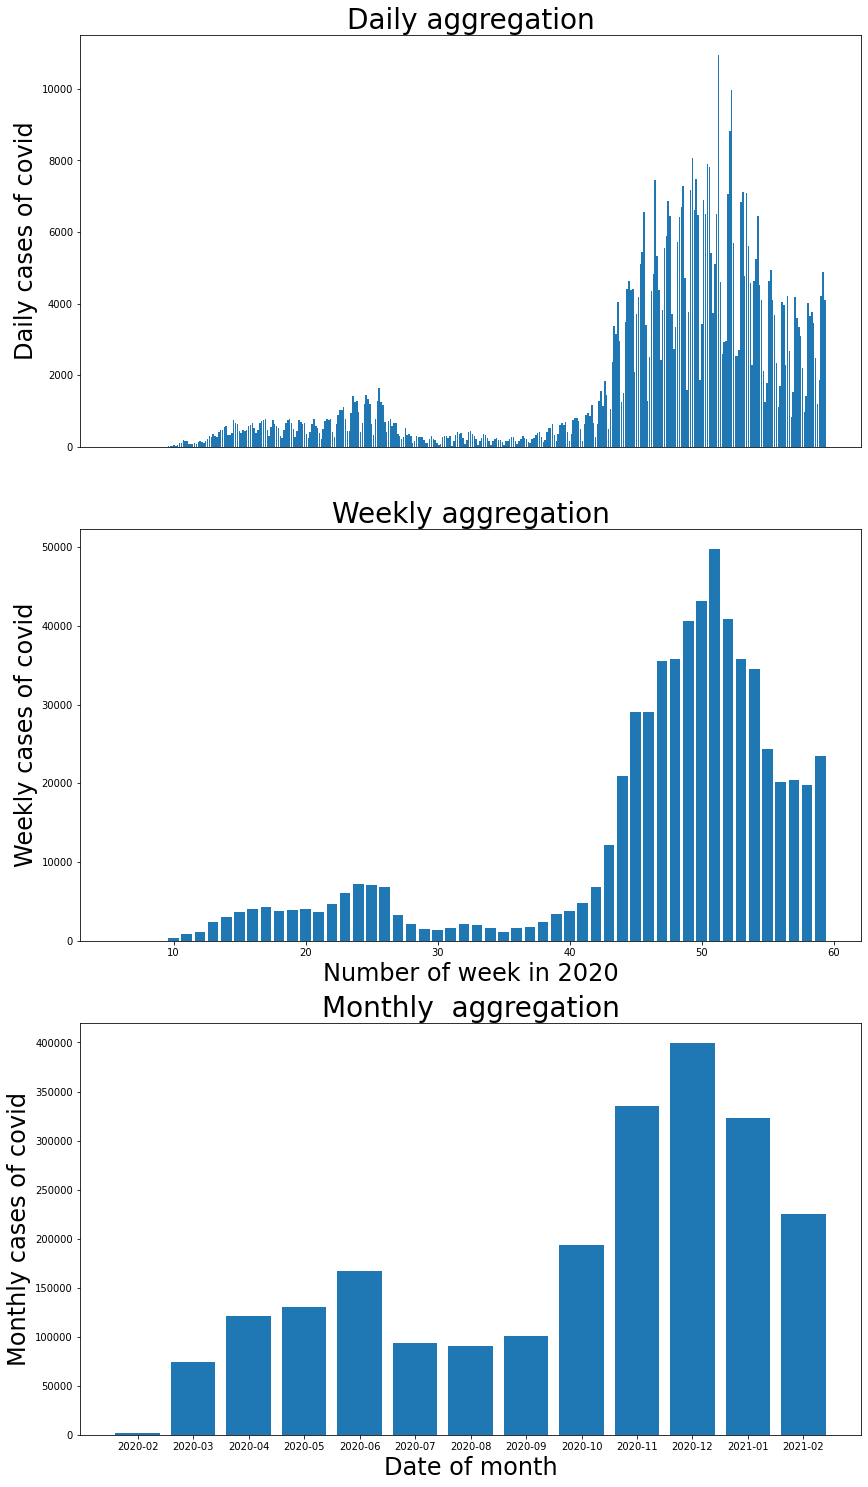

In [12]:
fig, ax = plt.subplots(3,1,figsize=(14,18))
ax[0].get_xaxis().set_visible(False)
ax[0].set_title("Daily aggregation",size=28)
ax[0].set_ylabel('Daily cases of covid',size=24)
ax[0].bar(diff_days,sumperday)

ax[1].bar(diff_weeks,sumperweek)
ax[1].set_title("Weekly aggregation",size=28)
ax[1].set_ylabel('Weekly cases of covid',size=24)
ax[1].set_xlabel('Number of week in 2020',size=24)


ax[2].bar(diff_months,sumspermonth)
ax[2].set_title("Monthly  aggregation",size=28)
ax[2].set_ylabel('Monthly cases of covid',size=24)
ax[2].set_xlabel('Date of month',size=24)

plt.subplots_adjust(bottom=-0.2)
plt.show()

{'mon': 1.778355186014284, 'tue': 2.8464182922929324, 'wed': 3.1640816544078456, 'thu': 2.8637938386099564, 'fri': 2.626159258074832, 'sat': 1.8814625306470525, 'sun': 1.0}


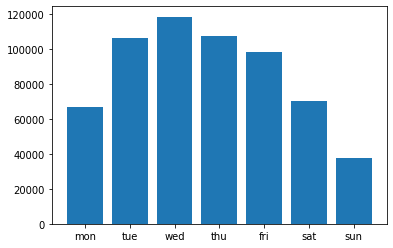

In [13]:
#figuring out if any of the days had more cases in them
counter=0
sumsperdaysofweek={'mon':0,'tue':0,'wed':0,'thu':0,'fri':0,'sat':0,'sun':0}
for i in sumperday:
    if counter==0:
        sumsperdaysofweek['tue']=sumsperdaysofweek['tue']+i
        counter+=1
    elif counter==1:
        sumsperdaysofweek['wed']=sumsperdaysofweek['wed']+i
        counter+=1
    elif counter==2:
        sumsperdaysofweek['thu']=sumsperdaysofweek['thu']+i
        counter+=1
    elif counter==3:
        sumsperdaysofweek['fri']=sumsperdaysofweek['fri']+i
        counter+=1
    elif counter==4:
        sumsperdaysofweek['sat']=sumsperdaysofweek['sat']+i
        counter+=1
    elif counter==5:
        sumsperdaysofweek['sun']=sumsperdaysofweek['sun']+i
        counter+=1
    elif counter==6:
        sumsperdaysofweek['mon']=sumsperdaysofweek['mon']+i
        counter=0
plt.bar(sumsperdaysofweek.keys(),sumsperdaysofweek.values())
# print(sumsperdaysofweek)
normsums=sumsperdaysofweek
for i in normsums:
    normsums[i]=normsums[i]/normsums['sun']
print(normsums)

<BarContainer object of 7 artists>

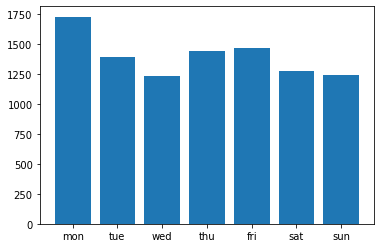

In [14]:
#same thing for denmark
sumperdaydk=[]
diff_daysdk=[]
counter=0
total=0
for i in coronadk.sort_values('date')['hospitalized_addition']:
    if counter<4:
        total=total+i
        counter+=1
    else:
        counter=0
        sumperdaydk.append(total)
        total=0
for i in coronadk['date']:
    if i not in diff_days:
        diff_days.append(i)
counter=0
sumsperdaysofweek={'mon':0,'tue':0,'wed':0,'thu':0,'fri':0,'sat':0,'sun':0}
for i in sumperdaydk:
    if counter==0:
        sumsperdaysofweek['sun']=sumsperdaysofweek['sun']+i
        counter+=1
        
    elif counter==1:
        sumsperdaysofweek['mon']=sumsperdaysofweek['mon']+i
        counter+=1
    elif counter==2:
        sumsperdaysofweek['tue']=sumsperdaysofweek['tue']+i
        counter+=1
    elif counter==3:
        sumsperdaysofweek['wed']=sumsperdaysofweek['wed']+i
        counter+=1
    elif counter==4:
        sumsperdaysofweek['thu']=sumsperdaysofweek['thu']+i
        counter+=1
    elif counter==5:
        sumsperdaysofweek['fri']=sumsperdaysofweek['fri']+i
        counter+=1
    elif counter==6:
        sumsperdaysofweek['sat']=sumsperdaysofweek['sat']+i
        counter=0
plt.bar(sumsperdaysofweek.keys(),sumsperdaysofweek.values())


In [15]:
def get_country_center(country):
    url = 'http://nominatim.openstreetmap.org/search?country='+country+'&format=json&polygon=0'
    response = requests.get(url).json()[0]
    return np.array([float(response.get(key)) for key in ['lat','lon']])
 
country_center = get_country_center("Sweden")
dkcenter=get_country_center('Denmark')

Folium map with GeoJson

In [16]:
m = folium.Map(location=country_center, zoom_start = 4)
m

Geodata visualization

- Make choropeth maps describing the corona cases in the country
- Use the folium.Choropleth function to connect the geoJSON with your dataframe
- To do so, you need to identify, in the geoJSON, which attribute contains the iso3166-2 code (note: if it is a sub-attribute of an attribute, you can refer to it as "attribute.sub_attribute").
- Visualize the CASES variable with an appropriate fill_color scale (check folium's documentation to know the allowed values)
- Visualize the population variable
- Create a cases per population variable and visualize that as well

In [17]:
#mapping number of cases in a choropleth map
m_cases = folium.Map(location=country_center, zoom_start = 4)

folium.Choropleth(
    geo_data = shapefiles,
    name = 'cases',
    data = coronabyiso,
    columns = ["isocodes", "cases"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases",
).add_to(m_cases)

m_cases

In [18]:
#mapping population density in a choropleth map
m_pop = folium.Map(location=country_center, zoom_start = 4)

folium.Choropleth(
    geo_data = shapefiles,
    name = "population",
    data = coronabyiso,
    columns = ["isocodes", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Population",
).add_to(m_pop)

m_pop

In [19]:
#mapping cases per capita in a choropleth map
coronabyiso['casespercapita']=coronabyiso['cases']/coronabyiso['population']

m_cases_pc = folium.Map(location=country_center, zoom_start = 4)

folium.Choropleth(
    geo_data = shapefiles,
    name = "cases",
    data = coronabyiso,
    columns = ["isocodes", "casespercapita"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases per Capita",
).add_to(m_cases_pc)

m_cases_pc

In [20]:
coronabyisodk['casespercapita']=coronabyisodk['cases']/coronabyisodk['population']

m_cases_pc_dk = folium.Map(location=dkcenter, zoom_start = 4)

folium.Choropleth(
    geo_data = shapefilesdk,
    name = "cases",
    data = coronabyisodk,
    columns = ["isocodes", "casespercapita"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases per Capita",
).add_to(m_cases_pc_dk)

m_cases_pc_dk

In [21]:
#merging corona and weather dataframes
initialcoronalen=len(corona)
initialweatherlen=len(weather)
#we lose ~200 rows in total since each data frame begins and ends at different dates
corona=corona.loc[corona['date'].isin(weather['date'])].sort_values(['isocodes','date'])
weather=weather.loc[weather['date'].isin(corona['date'])].sort_values(['iso3166-2','date'])


#merging corona and weather dataframes for denmark
coronadk=coronadk.loc[coronadk['date'].isin(weatherdk['date'])].sort_values(['isocodes','date'])
weatherdk=weatherdk.loc[weatherdk['date'].isin(coronadk['date'])].sort_values(['iso3166-2','date'])
#we lost


In [22]:
corona=corona.reset_index(drop=True)#reseting all indecies so that i can put the dfs together
weather=weather.reset_index(drop=True)
coronadk=coronadk.reset_index(drop=True)
weatherdk=weatherdk.reset_index(drop=True)

In [23]:


merged=pd.concat([weather,corona['confirmed_addition'],corona['region_code']],axis=1)
#Cleaning the column names beacause some of them were annoying to type
merged=merged.rename(columns={"confirmed_addition":'cases','region_code':'region','iso3166-2':'iso'})
print(initialcoronalen-len(merged)+initialweatherlen-len(merged))#number of rows lost

mergeddk=pd.concat([weatherdk,coronadk['hospitalized_addition'],coronadk['region_code']],axis=1)
mergeddk=mergeddk.rename(columns={"hospitalized_addition":'cases','region_code':'region','iso3166-2':'iso'})


252


Pearson and Spearman correlations

In [24]:
#making a list of columns to iterate over
statcols=['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
thresh=0.001/(len(statcols)*3)

In [25]:
#Pearson correlation
corrsum1=0
for i in statcols:
    corr, pvalue = pearsonr(merged["cases"], merged[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")
    corrsum1=corrsum1+abs(corr)

RelativeHumiditySurface
0.217	3.9070169220257783e-84	True

SolarRadiation
-0.222	5.0086720589042216e-88	True

Surfacepressure
0.130	6.031849091292155e-31	True

TemperatureAboveGround
-0.148	1.8154672522899836e-39	True

Totalprecipitation
0.016	0.15940712901941428	False

UVIndex
-0.233	4.673663032768274e-97	True

WindSpeed
0.043	0.00016318892865581133	False



In [26]:
corrsum3=0
for i in statcols:
    corr, pvalue = pearsonr(mergeddk["cases"], mergeddk[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")
    corrsum3=corrsum3+abs(corr)

RelativeHumiditySurface
-0.109	8.383366163205881e-05	False

SolarRadiation
-0.129	3.4064187180601246e-06	True

Surfacepressure
0.244	4.870548967101879e-19	True

TemperatureAboveGround
-0.396	6.0529366316561e-50	True

Totalprecipitation
-0.118	2.0495633338169144e-05	True

UVIndex
-0.363	1.2628288058745897e-41	True

WindSpeed
0.071	0.010923322432010423	False



In [27]:
#Spearman rank correlation
for i in statcols:
    corr, pvalue = spearmanr(merged["cases"], merged[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")

RelativeHumiditySurface
0.267	9.832250385730405e-128	True

SolarRadiation
-0.342	2.440997668619903e-213	True

Surfacepressure
0.155	2.411947739843351e-43	True

TemperatureAboveGround
-0.217	7.300739352215883e-84	True

Totalprecipitation
0.005	0.6392701606505318	False

UVIndex
-0.357	3.5946834739162764e-233	True

WindSpeed
-0.044	9.061463229959151e-05	False



In [28]:
for i in statcols:
    corr, pvalue = spearmanr(mergeddk["cases"], mergeddk[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")

RelativeHumiditySurface
0.012	0.6719275216139611	False

SolarRadiation
-0.239	2.6961644989760885e-18	True

Surfacepressure
0.186	1.4338841376592715e-11	True

TemperatureAboveGround
-0.411	6.140154193387304e-54	True

Totalprecipitation
-0.113	4.9239710324112844e-05	False

UVIndex
-0.488	2.201219939220438e-78	True

WindSpeed
0.083	0.0029236283459073797	False



In [29]:
#Log-transformed Pearson correlation
corrsum2=0
merged['cases']=merged['cases']+1
for i in statcols:
    corr, pvalue = pearsonr(np.log(merged['cases']), merged[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")
    corrsum2=corrsum2+abs(corr)
merged['cases']=merged['cases']-1
print(corrsum1/len(statcols)-corrsum2/len(statcols))

RelativeHumiditySurface
0.231	2.604923083457697e-95	True

SolarRadiation
-0.237	7.023729900514718e-100	True

Surfacepressure
0.175	8.922852858984709e-55	True

TemperatureAboveGround
-0.213	8.560860967210276e-81	True

Totalprecipitation
-0.025	0.030077619016782336	False

UVIndex
-0.245	4.3917687284067084e-107	True

WindSpeed
-0.060	1.359386703674533e-07	True

-0.025028690952378002


In [30]:
corrsum4=0
mergeddk['cases']=mergeddk['cases']+1
for i in statcols:
    corr, pvalue = pearsonr(np.log(mergeddk['cases']), mergeddk[i])
    print(f"{i}\n{corr:.3f}\t{pvalue}\t{pvalue < thresh}\n")
    corrsum4=corrsum4+abs(corr)
mergeddk['cases']=mergeddk['cases']-1
print(corrsum3/len(statcols)-corrsum4/len(statcols))

RelativeHumiditySurface
-0.038	0.1715080275901677	False

SolarRadiation
-0.221	8.483058555809854e-16	True

Surfacepressure
0.222	5.789103816982743e-16	True

TemperatureAboveGround
-0.423	2.8438766063311267e-57	True

Totalprecipitation
-0.126	5.1067767203773746e-06	True

UVIndex
-0.483	1.662617492680888e-76	True

WindSpeed
0.083	0.0027813804684090762	False

-0.023717210736289185


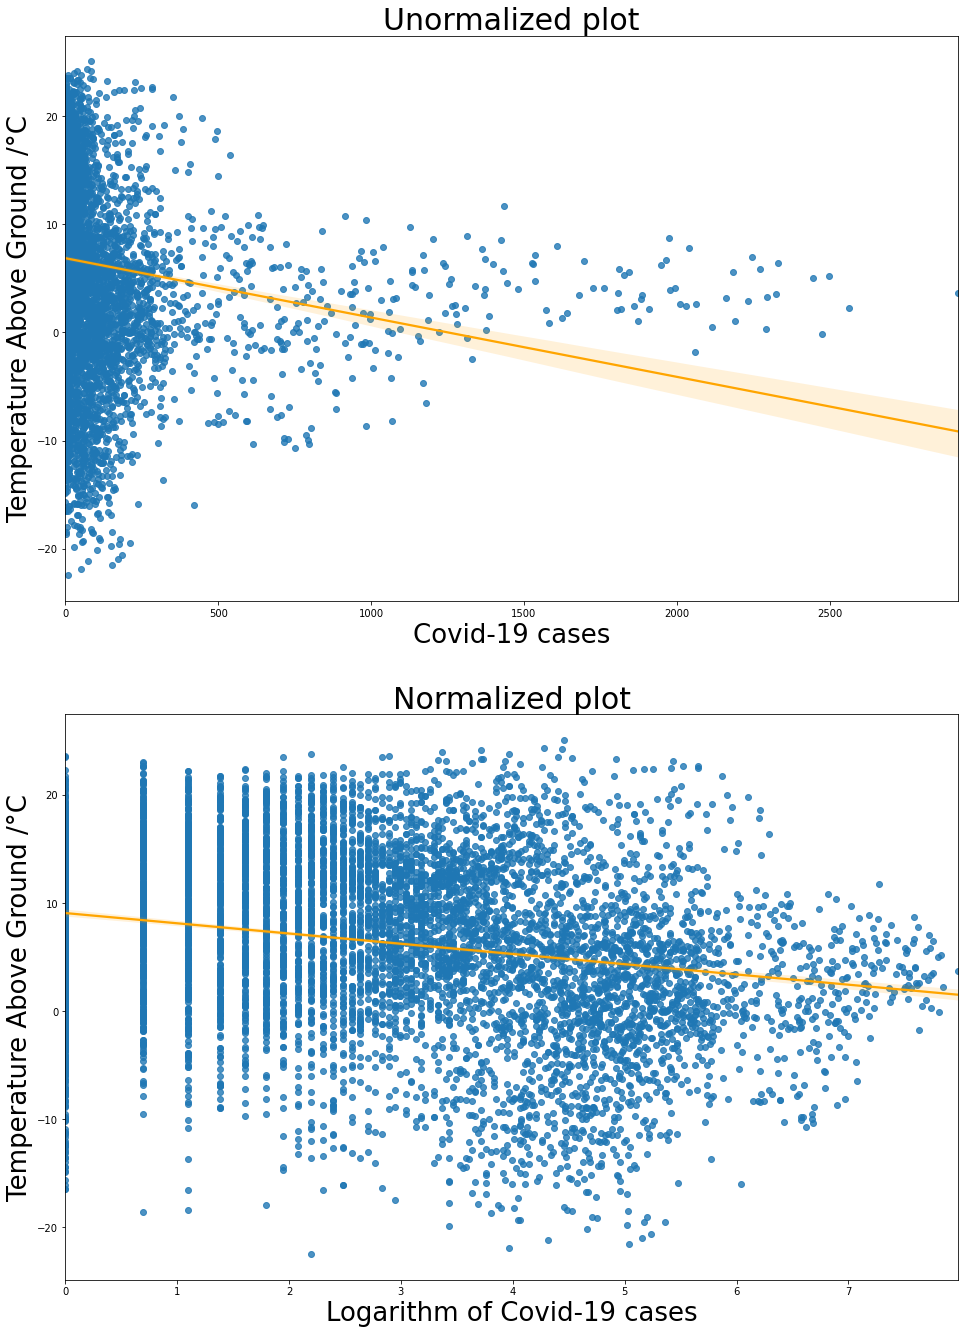

In [31]:
#making two scatter plots:
fig, ax = plt.subplots(2,1,figsize=(16,16))
# ax[0].scatter(merged["cases"],merged['SolarRadiation'])
# ax[1].scatter(np.log(merged['cases']), merged['UVIndex'])
sb.regplot(x=merged["cases"],y=merged['TemperatureAboveGround'],ax=ax[0],line_kws={'color':'orange'})
merged['cases']=merged['cases']+1
ax[0].set_title('Unormalized plot',fontsize=30)
ax[0].set_ylabel('Temperature Above Ground /°C',size=26)
ax[0].set_xlabel('Covid-19 cases',size=26)

sb.regplot(x=np.log(merged["cases"]),y=merged['TemperatureAboveGround'],ax=ax[1],line_kws={'color':'orange'})
ax[1].set_title('Normalized plot',fontsize=30)
ax[1].set_xlabel('Logarithm of Covid-19 cases',size=26)
ax[1].set_ylabel('Temperature Above Ground /°C',size=26)

plt.subplots_adjust(bottom=-0.2)
merged['cases']=merged['cases']-1
plt.show()


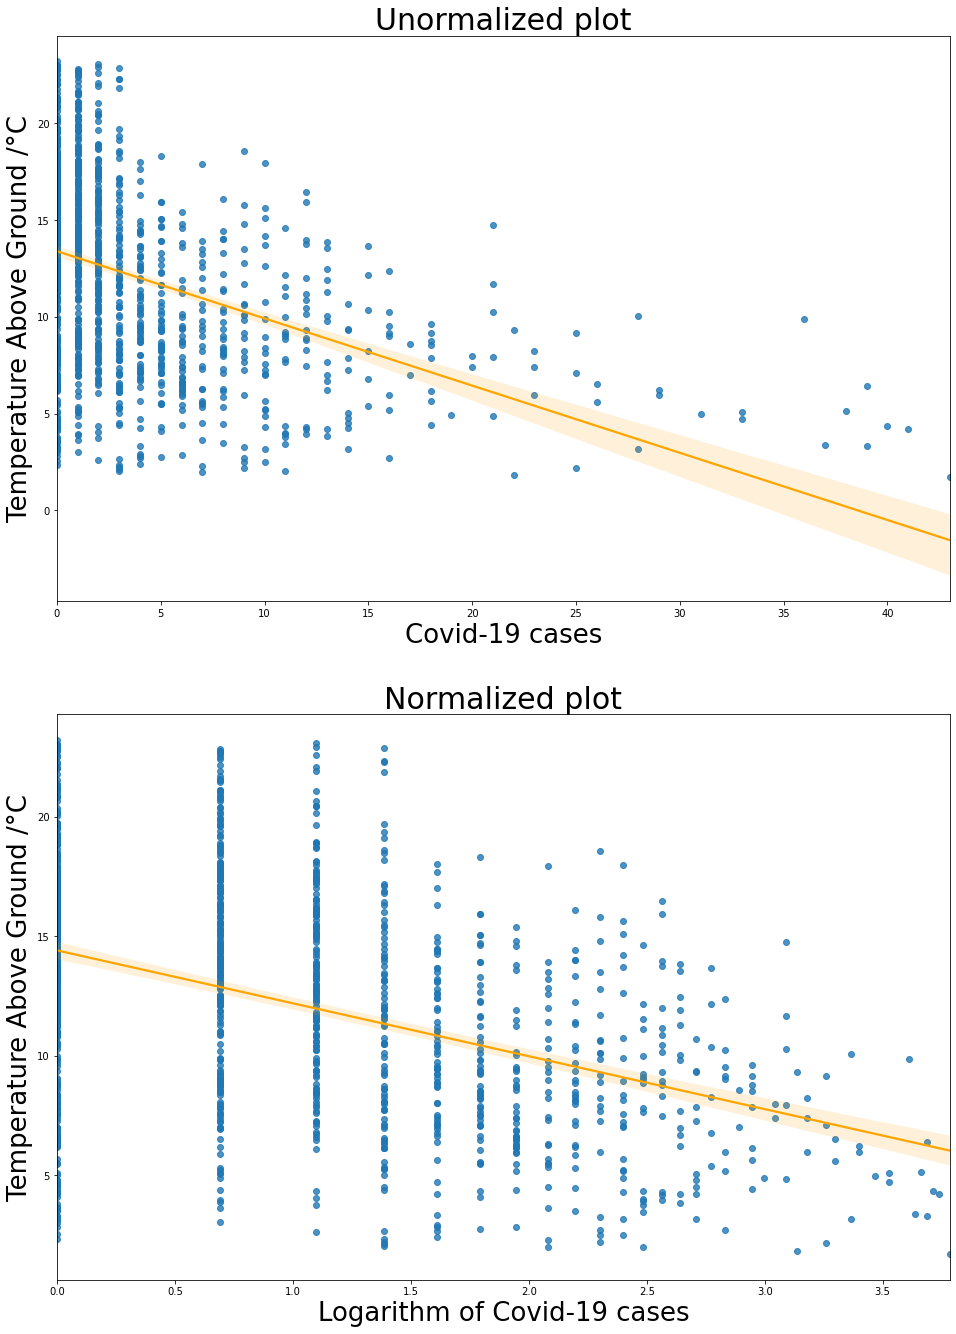

In [32]:
#making scatters for denmark
fig, ax = plt.subplots(2,1,figsize=(16,16))
# ax[0].scatter(merged["cases"],merged['SolarRadiation'])
# ax[1].scatter(np.log(merged['cases']), merged['UVIndex'])
sb.regplot(x=mergeddk["cases"],y=mergeddk['TemperatureAboveGround'],ax=ax[0],line_kws={'color':'orange'})
mergeddk['cases']=mergeddk['cases']+1
ax[0].set_title('Unormalized plot',fontsize=30)
ax[0].set_ylabel('Temperature Above Ground /°C',size=26)
ax[0].set_xlabel('Covid-19 cases',size=26)


sb.regplot(x=np.log(mergeddk["cases"]),y=mergeddk['TemperatureAboveGround'],ax=ax[1],line_kws={'color':'orange'})
ax[1].set_title('Normalized plot',fontsize=30)
ax[1].set_xlabel('Logarithm of Covid-19 cases',size=26)
ax[1].set_ylabel('Temperature Above Ground /°C',size=26)
plt.subplots_adjust(bottom=-0.2)
mergeddk['cases']=mergeddk['cases']-1
plt.show()


Multivariate linear regression on weather variables

In [33]:
#Making the constant from the lecture
merged=sm.add_constant(merged)
mergeddk=sm.add_constant(mergeddk)
statcols.append("const")

In [34]:
est = sm.OLS(merged["cases"], merged[statcols], hasconst = True).fit()
print(est.summary())
est = sm.OLS((mergeddk['cases']), mergeddk[statcols], hasconst = True).fit()
print('\n','\n','Denmark part below')
print(est.summary())
merged['cases']=merged['cases']+1
mergeddk['cases']=mergeddk['cases']+1

                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     122.5
Date:                Fri, 19 Mar 2021   Prob (F-statistic):          1.72e-171
Time:                        01:22:41   Log-Likelihood:                -52816.
No. Observations:                7812   AIC:                         1.056e+05
Df Residuals:                    7804   BIC:                         1.057e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [35]:
#now doing the same thing with all the log transformed number of cases
est = sm.OLS(np.log(merged['cases']), merged[statcols], hasconst = True).fit()
print(est.summary())



                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     188.5
Date:                Fri, 19 Mar 2021   Prob (F-statistic):          4.85e-259
Time:                        01:22:42   Log-Likelihood:                -15227.
No. Observations:                7812   AIC:                         3.047e+04
Df Residuals:                    7804   BIC:                         3.053e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [36]:
est = sm.OLS(np.log(mergeddk['cases']), mergeddk[statcols], hasconst = True).fit()
print('\n','\n','Denmark part below')
print(est.summary())



 
 Denmark part below
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     111.9
Date:                Fri, 19 Mar 2021   Prob (F-statistic):          4.05e-128
Time:                        01:22:42   Log-Likelihood:                -1442.0
No. Observations:                1295   AIC:                             2900.
Df Residuals:                    1287   BIC:                             2941.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Rel

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=24195024-9b97-4fbb-b643-b1da4ede0b31' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>